#### Cargamos el dataset y normalizamos las columnas

#### Aplicación de K-MEANS al CRISIS
* En este notebook 'KMeans_general', analizamos el dataset general en base a los valores de las etiquetas de los programas presidenciales. PAra cada país, para cada año en que tuvo elecciones, se ponderó cada variable por el % de votos que sacó cada programa; de esta manera tenemos un registro por país por año.
* Dado que hay algunos países en que la suma de las variables 'per' no es 100%, se normalizaron de forma de que sumaran 100%
* A fin de contar con una buena masa de datos, sólo se considerá las variables per principales ('per' + 3 dígitos). En total 46 variables.
* Se aplicó PCA para reducir las dimensiones
* Aplicamos K-MEANS
* Hicimos análisis de los países-años en cada cluster

#### Conclusiones
* 
* 

In [2]:
from sklearn.cluster import KMeans
import pandas as pd

# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['CRISIS_FINANCIERA_2008'],
    'var_1': ['per401'],
    'var_2': ['per403'],
    'var_3': ['per503'],  # None indica que no hay una tercera variable para el aspecto
    'var_4': ['per504']  
}

df_aspectos = pd.DataFrame(data_aspectos)
display(df_aspectos)

,aspecto,var_1,var_2,var_3,var_4
0,CRISIS_FINANCIERA_2008,per401,per403,per503,per504


#### 1.Filtrar y Normalizar datos

In [3]:
import pandas as pd
import numpy as np

# Cargar el dataset principal
file_path = './data/MP_Dataset_KMeans.xlsx'
df = pd.read_excel(file_path)

# Filtrar el DataFrame según las variables del aspecto seleccionado y el período
aspecto_filtro = 'CRISIS_FINANCIERA_2008'
desde = 2008
hasta = 2010

variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3', 'var_4']].dropna().values.flatten()

# Filtrar el DataFrame para las variables del aspecto, y normalizar si es necesario
df_filtered = df[(df['agno'] >= desde) & (df['agno'] <= hasta)][['countryname', 'agno'] + list(variables)].copy()
df_filtered.dropna(inplace=True)

# Normalizar las columnas per
columns_per = variables
df_filtered['per_sum'] = df_filtered[columns_per].sum(axis=1)
rows_to_normalize = df_filtered['per_sum'] != 1.0
df_filtered.loc[rows_to_normalize, columns_per] = df_filtered.loc[rows_to_normalize, columns_per].div(
    df_filtered.loc[rows_to_normalize, 'per_sum'], axis=0
)
df_filtered.drop(columns=['per_sum'], inplace=True)

# Verificar que las variables per sumen 1
assert df_filtered[columns_per].sum(axis=1).round(6).eq(1).all(), "Error: las variables per no suman 1."


In [4]:
print(df_filtered.info())
print(df_filtered.head(10))


<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, 44 to 734
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   countryname  41 non-null     object 
 1   agno         41 non-null     int64  
 2   per401       41 non-null     float64
 3   per403       41 non-null     float64
 4   per503       41 non-null     float64
 5   per504       41 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.2+ KB
None
            countryname  agno    per401    per403    per503    per504
44            Australia  2010  0.012148  0.025497  0.083181  0.879175
67              Austria  2008  0.041235  0.057848  0.595495  0.305423
93              Belgium  2010  0.091680  0.242014  0.266505  0.399802
96              Bolivia  2009  0.020975  0.108665  0.168893  0.701466
103  Bosnia-Herzegovina  2010  0.031603  0.043429  0.076894  0.848074
109              Brazil  2010  0.012017  0.088665  0.247715  0.651603
115     

#### 2.Realizar PCA

In [5]:
from sklearn.decomposition import PCA

# Seleccionar sólo las columnas numéricas (per) para PCA
numeric_data = df_filtered[columns_per]

# Ejecutar PCA
pca = PCA(n_components=3)
pca_components = pca.fit_transform(numeric_data)

# Crear un DataFrame con las componentes principales
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2', 'PC3'])

# Combinar con las columnas categóricas
df_pca = pd.concat([df_filtered[['countryname', 'agno']].reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

# Verificar el resultado
print(df_pca.info())
print(df_pca.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   countryname  41 non-null     object 
 1   agno         41 non-null     int64  
 2   PC1          41 non-null     float64
 3   PC2          41 non-null     float64
 4   PC3          41 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.7+ KB
None
          countryname  agno       PC1       PC2       PC3
0           Australia  2010 -0.390829 -0.112604 -0.021970
1             Austria  2008  0.369782 -0.208598 -0.098168
2             Belgium  2010  0.134717  0.085950  0.009486
3             Bolivia  2009 -0.188007 -0.044833 -0.035848
4  Bosnia-Herzegovina  2010 -0.364913 -0.087820 -0.001452
5              Brazil  2010 -0.106490 -0.089008 -0.059995
6            Bulgaria  2009 -0.003910  0.060439  0.066660
7              Canada  2008  0.096732  0.185065 -0.073782
8              

In [6]:
# df_pca

#### 3.Elbow + K-MEANS

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

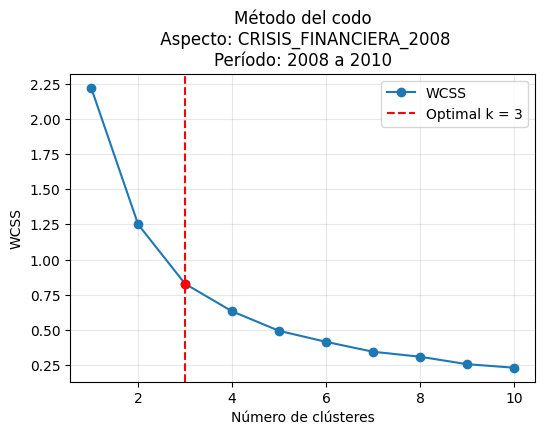

El número óptimo de clústeres según el método del codo es: 3


In [11]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt

# Usar los datos normalizados de 'numeric_data' para calcular WCSS
data_scaled = numeric_data  # Asegúrate de que sea el conjunto de datos numéricos normalizados

# Calcular WCSS para determinar el número óptimo de clústeres
max_k = 10
wcss = []
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Encontrar el codo automáticamente
kl = KneeLocator(range(1, max_k + 1), wcss, curve="convex", direction="decreasing")
optimal_k = kl.knee

# Graficar el método del codo
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_k + 1), wcss, marker='o', label="WCSS")
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.scatter(optimal_k, wcss[optimal_k - 1], color='red', zorder=5)  # Punto del codo
plt.title(f"Método del codo\n Aspecto: {aspecto_filtro}\nPeríodo: {desde} a {hasta}")
plt.xlabel('Número de clústeres')
plt.ylabel('WCSS')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"El número óptimo de clústeres según el método del codo es: {optimal_k}")


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


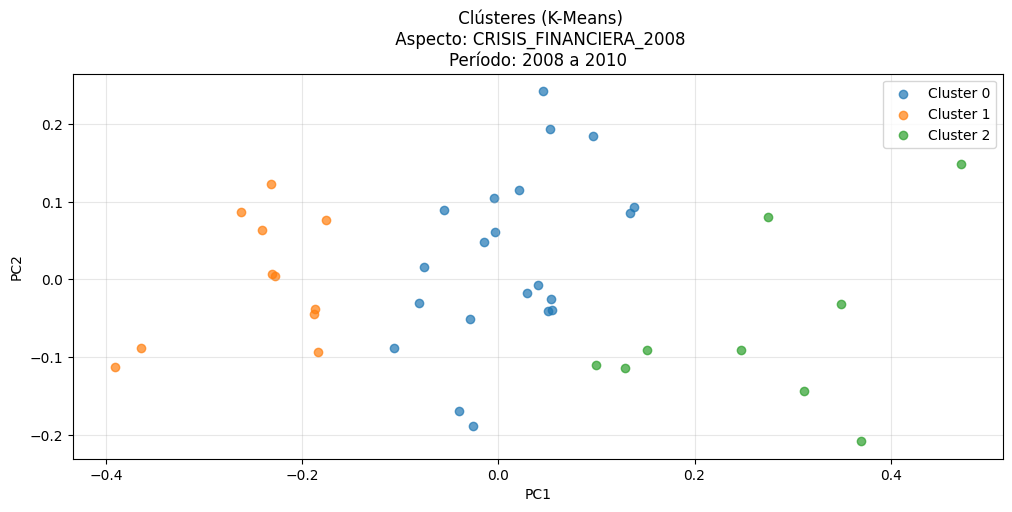

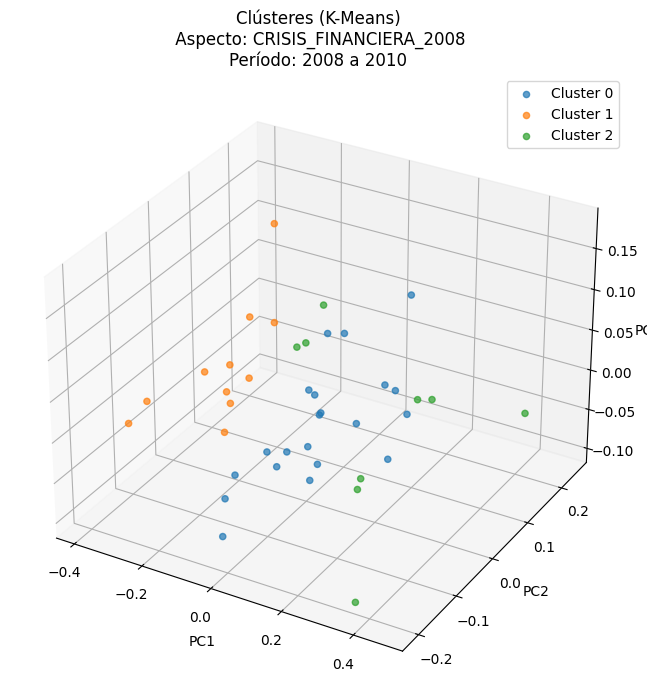

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Aplicar K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2', 'PC3']])

# Visualizar clústeres en 2D
plt.figure(figsize=(12, 5))
for cluster in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title(f" Clústeres (K-Means)\n Aspecto: {aspecto_filtro}\nPeríodo: {desde} a {hasta}")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Visualizar clústeres en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}', alpha=0.7)

ax.set_title(f"Clústeres (K-Means)\n Aspecto: {aspecto_filtro}\nPeríodo: {desde} a {hasta}")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.show()


#### 4.Visualizar clusters

In [8]:
# Explorar los países y períodos en cada clúster
for cluster in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Total Programas: {len(cluster_data)}")
    print("Países y años:")
    display(cluster_data)
    # for country, group in cluster_data.groupby('countryname'):
    #     years = group['agno'].tolist()
    #     print(f"- {country}: {len(years)} programas ({', '.join(map(str, years))})")



Cluster 0:
Total Programas: 21
Países y años:


,countryname,agno,PC1,PC2,PC3,cluster
2,Belgium,2010,0.134717,0.085950,0.009486,0
5,Brazil,2010,-0.106490,-0.089008,-0.059995,0
6,Bulgaria,2009,-0.003910,0.060439,0.066660,0
7,Canada,2008,0.096732,0.185065,-0.073782,0
8,Chile,2009,0.138138,0.092694,-0.086835,0
9,Colombia,2010,-0.028705,-0.050659,-0.055949,0
10,Costa Rica,2010,0.040457,-0.006687,-0.062939,0
11,Czech Republic,2010,-0.004404,0.105461,0.048790,0
15,Hungary,2010,0.020778,0.115535,-0.066052,0
19,Latvia,2010,-0.075435,0.016581,-0.072434,0



Cluster 1:
Total Programas: 11
Países y años:


,countryname,agno,PC1,PC2,PC3,cluster
0,Australia,2010,-0.390829,-0.112604,-0.021970,1
3,Bolivia,2009,-0.188007,-0.044833,-0.035848,1
4,Bosnia-Herzegovina,2010,-0.364913,-0.087820,-0.001452,1
17,Italy,2008,-0.175931,0.076907,0.174096,1
18,Japan,2009,-0.231262,0.007328,-0.026834,1
22,Moldova,2009,-0.262971,0.086674,0.045849,1
23,Moldova,2010,-0.231809,0.123447,0.028029,1
24,Montenegro,2009,-0.187074,-0.038760,0.012319,1
27,North Macedonia,2008,-0.227777,0.004728,0.023032,1
28,Norway,2009,-0.184056,-0.093858,0.059853,1



Cluster 2:
Total Programas: 9
Países y años:


,countryname,agno,PC1,PC2,PC3,cluster
1,Austria,2008,0.369782,-0.208598,-0.098168,2
12,Ecuador,2009,0.247706,-0.091529,-0.029696,2
13,Georgia,2008,0.099211,-0.110293,0.130847,2
14,Germany,2009,0.471404,0.148194,-0.009506,2
16,Iceland,2009,0.312174,-0.143225,0.014820,2
25,Netherlands,2010,0.349045,-0.031609,0.066986,2
26,New Zealand,2008,0.151231,-0.090394,0.178405,2
34,Slovenia,2008,0.128676,-0.114299,0.141016,2
40,United States,2008,0.275151,0.080553,0.011180,2


#### 5. Análisis de clusters